In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds

In [3]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [48]:
IMG_SIZE = 64  # Reduced from 64 to 32 for speed
LATENT_DIM = 100
BATCH_SIZE = 256  # Larger batch size speeds up training
EPOCHS = 50  # Will stop early if needed
BUFFER_SIZE = 20000

In [49]:
# Load Oxford Flowers dataset
dataset, info = tfds.load("oxford_flowers102", split="train", as_supervised=True, with_info=True)

# Filter dataset to include only class 1 (e.g., Roses)
dataset = dataset.filter(lambda img, label: label == 1)

# Preprocess function
def preprocess(image, label):
    image = tf.image.resize(image, (64, 64))  # Resize for faster training
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Apply preprocessing
dataset = dataset.map(preprocess).batch(BATCH_SIZE).shuffle(5000)


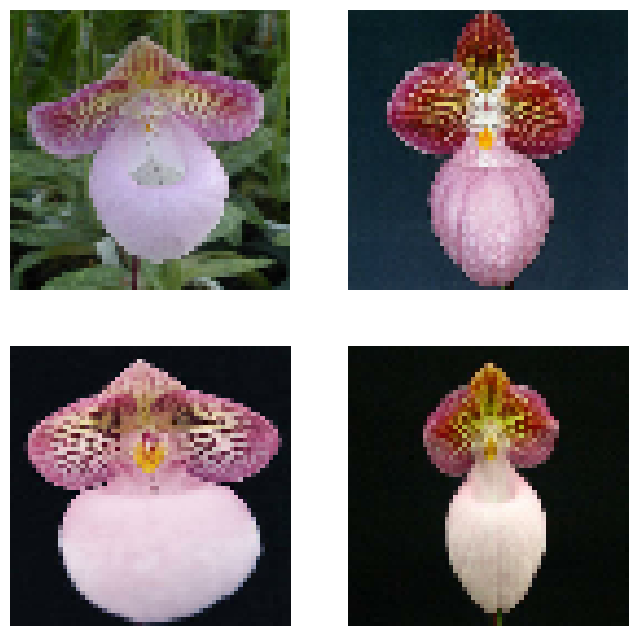

In [32]:
# prompt: show 4 x 4 images from dataset

import matplotlib.pyplot as plt

# Take the first batch of images from the dataset
images = next(iter(dataset))

# Create a 2x2 grid of images
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Iterate through the first 4 images in the batch
for i in range(4):
  row = i // 2
  col = i % 2

  # Rescale the image to [0, 1] for display
  image = (images[i] + 1) / 2.0

  axes[row, col].imshow(image)
  axes[row, col].axis('off')

plt.show()


In [33]:
def build_generator():
    model = keras.Sequential([
        layers.Dense(4*4*512, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(), layers.ReLU(),
        layers.Reshape((4, 4, 512)),
        layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(), layers.ReLU(),
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(), layers.ReLU(),
        layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(), layers.ReLU(),
        layers.Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', activation='tanh')
    ])
    return model

In [53]:
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.LeakyReLU(alpha=0.2), layers.Dropout(0.3),
        layers.Conv2D(128, (4,4), strides=(2,2), padding='same'),
        layers.LeakyReLU(alpha=0.2), layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [54]:
generator = build_generator()
discriminator = build_discriminator()

In [55]:
print(generator.summary())
print(discriminator.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 8192)                │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 8, 8, 256)           │       2,097,152 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_15 (ReLU)                      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 16, 16, 128)         │         524,288 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_16 (ReLU)                      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 32, 32, 64)          │         131,072 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_17 (ReLU)                      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (None, 64, 64, 3)           │           3,075 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,609,347 (13.77 MB)

 Trainable params: 3,592,067 (13.70 MB)

 Non-trainable params: 17,280 (67.50 KB)

None


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,105 (652.75 KB)

 Trainable params: 167,105 (652.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
dataset = dataset.batch(BATCH_SIZE).shuffle(5000)


In [37]:
cross_entropy = keras.losses.BinaryCrossentropy()
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)  # Faster learning rate
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5)


In [57]:
# @tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [58]:
for batch in dataset.take(1):
    real_images = batch
    print(real_images.shape)  # Should print (batch_size, 64, 64, 3)

    noise = tf.random.normal([256, LATENT_DIM])
    fake_images = generator(noise, training=False)
    print(fake_images.shape)  # Should also print (batch_size, 64, 64, 3)


(10, 64, 64, 3)
(256, 64, 64, 3)


In [67]:
start_time = time.time()
for epoch in range(10000):
    for batch in dataset.take(1000):  # Only take 50 batches per epoch for speed
        gen_loss, disc_loss = train_step(batch)

    print(f"Epoch {epoch+1}: Gen Loss={gen_loss:.4f}, Disc Loss={disc_loss:.4f}")

    if time.time() - start_time > 600:  # Stop after 10 minutes
        print("Stopping training after 10 minutes.")
        break

Epoch 1: Gen Loss=0.6854, Disc Loss=0.9255
Epoch 2: Gen Loss=1.8132, Disc Loss=0.6110
Epoch 3: Gen Loss=1.5464, Disc Loss=0.6568
Epoch 4: Gen Loss=1.2188, Disc Loss=0.6303
Epoch 5: Gen Loss=1.9185, Disc Loss=0.6625
Epoch 6: Gen Loss=0.9200, Disc Loss=0.7116
Epoch 7: Gen Loss=1.8188, Disc Loss=0.7916
Epoch 8: Gen Loss=1.2930, Disc Loss=0.6277
Epoch 9: Gen Loss=1.4694, Disc Loss=0.5934
Epoch 10: Gen Loss=1.7813, Disc Loss=0.6743
Epoch 11: Gen Loss=1.0847, Disc Loss=0.6818
Epoch 12: Gen Loss=1.9785, Disc Loss=0.6203
Epoch 13: Gen Loss=1.2122, Disc Loss=0.6145
Epoch 14: Gen Loss=1.7622, Disc Loss=0.5867
Epoch 15: Gen Loss=1.6281, Disc Loss=0.4939
Epoch 16: Gen Loss=1.4871, Disc Loss=0.5131
Epoch 17: Gen Loss=1.6083, Disc Loss=0.6599
Epoch 18: Gen Loss=0.8776, Disc Loss=0.8851
Epoch 19: Gen Loss=1.6117, Disc Loss=0.7054
Epoch 20: Gen Loss=1.2443, Disc Loss=0.6264
Epoch 21: Gen Loss=1.5602, Disc Loss=0.6587
Epoch 22: Gen Loss=1.0781, Disc Loss=0.6813
Epoch 23: Gen Loss=1.8035, Disc Loss=0.66

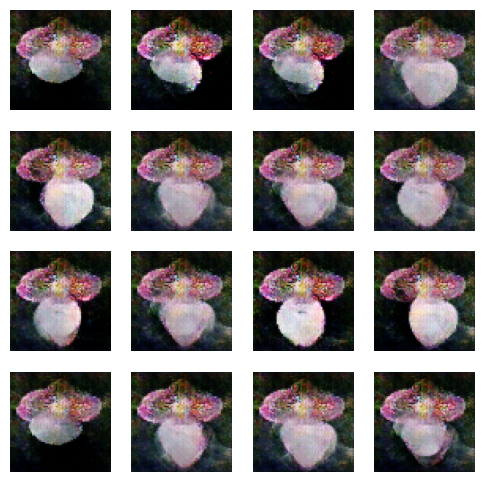

In [68]:
def generate_and_show_images():
    noise = tf.random.normal([16, LATENT_DIM])  # Latent vector of shape (16, LATENT_DIM)
    generated_images = generator(noise, training=False)  # Generate images
    generated_images = (generated_images + 1) / 2  # Rescale from [-1, 1] to [0, 1]

    # Ensure the images are in float32 dtype for proper visualization
    generated_images = tf.cast(generated_images, tf.float32)

    # Set up a 4x4 grid to display the images
    fig, axs = plt.subplots(4, 4, figsize=(6,6))  # 4x4 grid for 16 images
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(generated_images[i * 4 + j].numpy())  # Convert to numpy array and display
            axs[i, j].axis('off')  # Turn off axis for clarity

    plt.show()

# Generate and show images
generate_and_show_images()

In [ ]:
/